In [97]:
import copy
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from scipy.stats import entropy

import torch.optim as optim
import cv2
from torchvision import utils

# Assignment 3

## Generative Adversarial Networks on MNIST

In this assignment you will create and train a GAN to generate images of digits that mimic those in the MNIST dataset.

### Evaluation metric: Inception Score

Rather than just eye-balling whether GAN samples look good or not, researchers have come up with mulitple objective metrics for determining the quality and the diversity of GAN outputs. We will use one of the metrics called the *Inception Score*.

Calculating the Inception Score involves running a pretrained neural network. This is where the name is from: the authors who proposed this metric used a pretrained [Inception Network](https://arxiv.org/pdf/1409.4842.pdf) from Tensorflow in their [paper](https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf). Since we will be using the MNIST dataset in this assignment, we provide a simpler neural work pretrained on MNIST as the scoring model.

The idea behind the Inception Score is simple: a good GAN should generate *meaningful* and *diverse* samples. For MNIST, a specific sample is "meaningful" if it looks like any of the 10 digits. When we take a good digit classifier and run it on this sample, it should assign high probability to one of the 10 classes and low probability to the others. In information theory terms, this means the predicted label distribution $p(y|x)$ for any specific sample $x$ should have high entropy. On the other hand, if the generated samples are diverse, they should be able to cover all 10 classes when we generate a large enough set of samples. This means that the "average" label distribution $p(y) = \int p(y|x=G(z)) \mathrm{d}z$ should have low entropy. The Inception Score is define by $\exp (\mathbb{E}_x \mathrm{KL}(p(y|x) || p(y)))$, where $\mathrm{KL}(P||Q)$ is the K-L divergence, which is often used to measure how probability distribution $P$ is different from distribution $Q$. Intuitively, if the generated samples are good, $p(y|x)$ should be different from $p(y)$, since one should have high entropy while the other should have low entropy.

Don't be too worried if you don't fully get how the score is defined and calculated. Just remember that in this assignment, we want our GAN to have a high Inception Score.

In [98]:
# Pretrained model used to evaluation the inception score.
class ScoringModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    
def inception_score_mnist(
    imgs,
    model_path='weights/mnist.ckpt',
    batch_size=32,
    num_splits=10,
):
    """Computes the inception score of `imgs`.
    
    Args:
    - imgs: Array of size (number of data points, 1, 28, 28)
    - batch_size: Batch size for feeding data into the pretrained MNIST model.
    - num_splits: Number of splits. We split the samples into multiple subsets
        and calculate the scores on each of them. Their mean is used as the
        final score.
    """
    # Verify that input arguments have the correct formats.
    assert type(imgs) == np.ndarray
    assert imgs.shape[1:] == (1, 28, 28)
    assert batch_size > 0
    assert len(imgs) > batch_size
    
    # Choose device to be used.
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    # Preprocess input.
    imgs = copy.copy(imgs)
    imgs = (imgs - 0.1307) / 0.3081
    
    # Set up dataloader.
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load pretrained scoring model.
    model = ScoringModel()
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    # Get predictions.
    preds = []
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        with torch.no_grad():
            logits = model(batch)
            probs = F.softmax(logits, dim=1).cpu().numpy()
        preds.append(probs)
    preds = np.concatenate(preds)

    # Compute the mean KL divergence.
    split_scores = []

    for i in range(num_splits):
        n = len(imgs) // num_splits
        split = preds[i*n:(i+1)*n, :]
        py = np.mean(split, axis=0)
        scores = []
        for i in range(split.shape[0]):
            pyx = split[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

Now, let's try to calculate the Inception score on the actual MNIST dataset.

Make sure that the provided file `mnist.ckpt` is under `./weights`. Alternatively, you can specify its path via the `model_path` argument of `inception_score_mnist()`. If using Google Colab, click `View > Table of Contents > Files` and then upload it.

In [99]:
transform = torchvision.transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size=500, shuffle=True)
x, _ = next(iter(train_loader))
x = x.cpu().data.numpy()
x = x.reshape((-1,1,28,28))
print('Shape of data:',x.shape)
mean, std = inception_score_mnist(x)
print(f'Inception Score: mean={mean:.3f}, std={std:.3f}')

Shape of data: (500, 1, 28, 28)
Inception Score: mean=8.597, std=0.396


The score for the real MNIST dataset should be above 8.


### Generating MNIST images (100 points)

As you did with the Gaussian distribution example in the weekly notebook, define and train a GAN to generate images that mimic those in the MNIST dataset.

#### Deliverables

- After training your model, generate at least 1500 samples using the trained generator, and evaluate your model by calculating the Inception score on the generated samples.
- Pick a few generated samples and visualize them.
- Plot the training losses for the discriminator and the generator.

Given the limited computational resources, you will want to achieve an Inception score of 1.5 or greater for full credits. A score of 1.5 won't yield great images. For nice looking images, you'll need an Inception score of around 6.0, but it is not needed for full credits.

#### Model Submission

For more complicated architectures, if your model takes a long time to train, you will need to save the model and write a code snippet that loads it such that the code runs with no errors and we can grade it easily. In this case, set `epochs = 0` and include the saved model in your submission (or a Google drive share link if its too large).

#### Tips

- It will be easier to get better results with a convolutional GAN. You may find this [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) on [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) helpful. The generators of DCGANs make use of transposed convolutions (`nn.ConvTranspose2d` in PyTorch) to map features to larger sizes. This [article](https://d2l.ai/chapter_computer-vision/transposed-conv.html) does a good job illustrating how they work.
- Feel free to try different architectures, layers, optimizers, training schemes and other hyperparameters. Particularly, if training with one type of optimizer is slow or unstable, give other types of optimizers a try.

There are plenty of online resources about GAN that you can reference for inspiration. But do not plagiarize. Please write your own custom networks.

In [100]:
# Root directory for dataset
dataroot = "./data" #"data/mnist"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 150

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [101]:
train_data = dset.MNIST(
    root=dataroot,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    download=True
)
test_data = dset.MNIST(
    root=dataroot,
    train=False,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
dataset = train_data+test_data

In [102]:
dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

In [103]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

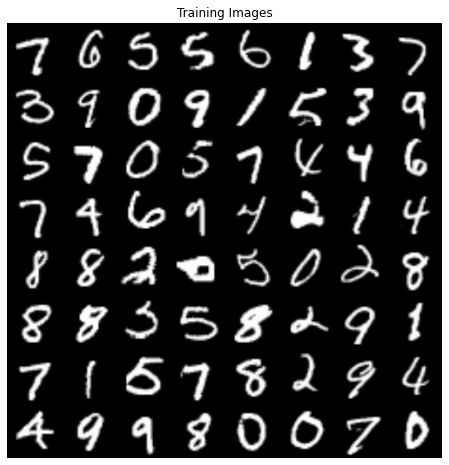

In [104]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [105]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [106]:
# TODO
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # nn.ConvTranspose2d(nc, 16, kernel_size=4, stride=1, padding=1), 
            # nn.BatchNorm2d(16), 
            # nn.Dropout2d(0.2),
            # nn.ReLU(),
            # nn.Conv2d(16,16, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=0), 
            # nn.BatchNorm2d(8),
            # nn.Dropout2d(0.2),
            # nn.ReLU(),
            # nn.Conv2d(8,8, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=0), 
            # nn.BatchNorm2d(4),
            # # nn.Dropout2d(0.2),
            # nn.ReLU(), 
            # nn.Conv2d(4,4, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.ConvTranspose2d(4, 4, kernel_size=4, stride=2, padding=1), 
            # nn.ReLU(),
            # nn.Conv2d(4,1 , kernel_size=3, stride=1, padding=1),
            # nn.Sigmoid()
            

            ##################################################

            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            #nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            #nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 3, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32 state size. (ngf) x 28 x 28
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            #nn.ConvTranspose2d( ngf, nc, 4, 1, 2, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64 state size. (ngf) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

In [107]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [108]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=1),
            # nn.LeakyReLU(0.5),
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=1),
            # nn.LeakyReLU(0.5),
            # nn.Dropout2d(0.2),
            # nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2, padding=1),
            # nn.LeakyReLU(0.5),
            # nn.Dropout2d(0.2),
            # nn.Flatten(),
            # nn.Linear(32*5*5, 1),
            # # nn.Linear(128,1),
            # nn.Sigmoid()


            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            #nn.Conv2d(nc, ndf, 4, 1, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32 #28
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            #nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16 #14
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            #nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8 #7
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            #nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4 #7
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [109]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [110]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(100, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [111]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

# Save the model
torch.save(netG.state_dict(),'./model')

Starting Training Loop...
[0/5][0/467]	Loss_D: 1.6073	Loss_G: 4.4862	D(x): 0.6175	D(G(z)): 0.5835 / 0.0176
[0/5][50/467]	Loss_D: 0.0231	Loss_G: 7.7957	D(x): 0.9886	D(G(z)): 0.0097 / 0.0005
[0/5][100/467]	Loss_D: 3.3159	Loss_G: 21.9984	D(x): 0.9528	D(G(z)): 0.9389 / 0.0000
[0/5][150/467]	Loss_D: 0.5878	Loss_G: 7.4154	D(x): 0.9722	D(G(z)): 0.3973 / 0.0011
[0/5][200/467]	Loss_D: 0.4890	Loss_G: 2.1729	D(x): 0.6956	D(G(z)): 0.0519 / 0.1607
[0/5][250/467]	Loss_D: 0.3071	Loss_G: 4.3737	D(x): 0.8884	D(G(z)): 0.1548 / 0.0186
[0/5][300/467]	Loss_D: 4.3048	Loss_G: 0.0657	D(x): 0.0348	D(G(z)): 0.0000 / 0.9386
[0/5][350/467]	Loss_D: 0.4933	Loss_G: 2.1596	D(x): 0.6828	D(G(z)): 0.0492 / 0.1528
[0/5][400/467]	Loss_D: 0.2938	Loss_G: 2.4032	D(x): 0.8352	D(G(z)): 0.0942 / 0.1139
[0/5][450/467]	Loss_D: 0.1916	Loss_G: 3.9044	D(x): 0.9612	D(G(z)): 0.1346 / 0.0282
[1/5][0/467]	Loss_D: 1.4224	Loss_G: 2.6196	D(x): 0.8741	D(G(z)): 0.6518 / 0.1045
[1/5][50/467]	Loss_D: 0.3378	Loss_G: 2.7114	D(x): 0.8998	D(G(z)):

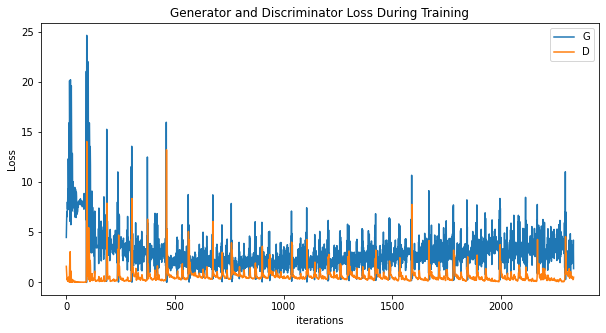

In [112]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

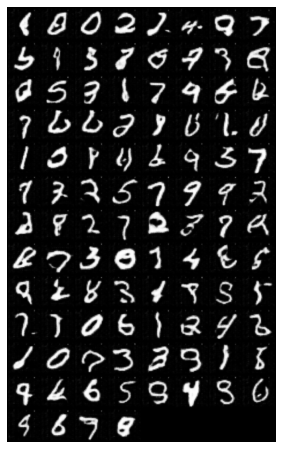

In [113]:
# import matplotlib.animation as animation
# from IPython.display import HTML
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

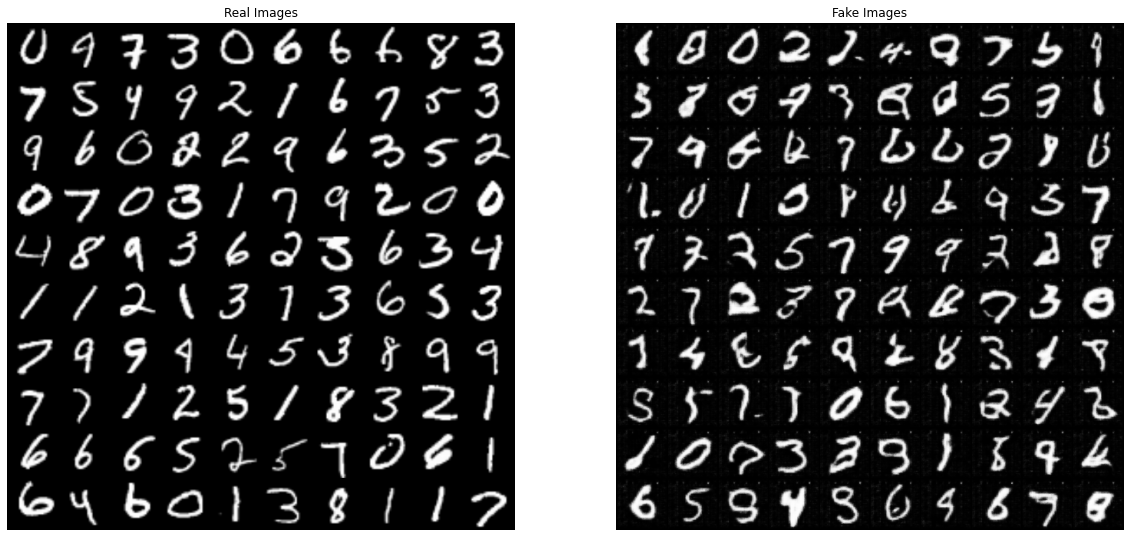

In [114]:
# Size of the Figure
plt.figure(figsize=(20,10))

# Plot the real images
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
real = next(iter(dataloader))
plt.imshow(utils.make_grid(real[0][:100]*0.5+0.5, nrow=10).permute(1, 2, 0))

# Load the Best Generative Model
netG = Generator(0)
netG.load_state_dict(torch.load('./model', map_location=torch.device('cpu')))
netG.eval()

# Generate the Fake Images
with torch.no_grad():
    fake = netG(fixed_noise.cpu())

# Plot the fake images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
fake = utils.make_grid(fake*0.5+0.5, nrow=10)
plt.imshow(fake.permute(1, 2, 0))

# Save the comparation result
# plt.savefig('result.jpg', bbox_inches='tight')

In [122]:
n_fake = 1500
noise = torch.randn(n_fake, nz, 1, 1, device=device)
with torch.no_grad():
  fake = netG(noise.cpu())
x = fake.data.numpy()
x = x.reshape((-1,1,image_size,image_size))
res = np.zeros([n_fake,1,28,28],dtype=np.float32)
#plt.imshow(x[0][0])
for i in range(n_fake):  
  res[i][0] = cv2.resize(x[i][0], dsize=(28,28))#, interpolation=cv2.INTER_CUBIC)
mean, std = inception_score_mnist(res)
print(f'Inception Score: mean={mean:.3f}, std={std:.3f}')

Inception Score: mean=1.381, std=0.063
